In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
import numpy as np
from torchvision import datasets, transforms


### make dataloader

In [2]:
# load patches data from files
train_images_patches = torch.load('data/mnist77_train.pt')
test_images_patches = torch.load('data/mnist77_test.pt')

# get the label from datasets.MNIST
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)
train_labels = [label for _, label in train_dataset]
test_labels = [label for _, label in test_dataset]
train_labels = torch.LongTensor(train_labels)
test_labels = torch.LongTensor(test_labels)

# make them to be PyTorch tensors, and dataloader
# train_dataset = torch.utils.data.TensorDataset(train_images_patches[:100], train_labels[:100])
# test_dataset = torch.utils.data.TensorDataset(test_images_patches[:100], test_labels[:100])
train_dataset = torch.utils.data.TensorDataset(train_images_patches, train_labels)
test_dataset = torch.utils.data.TensorDataset(test_images_patches, test_labels)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# test dataloader
for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break


torch.Size([64, 49, 25])
torch.Size([64])


### Clamp -1,1

In [5]:
# define a model
# define sub model first
class SubModel(nn.Module):
    def __init__(self, device):
        super(SubModel, self).__init__()
        self.fc0 = nn.Linear(13, 11, bias=False)
        self.fc1 = nn.Linear(11, 9, bias=False)
        self.fc2 = nn.Linear(9, 7, bias=False)
        self.fc3 = nn.Linear(7, 5, bias=False)
        self.fc4 = nn.Linear(5, 3, bias=False)
        self.fc5 = nn.Linear(3, 1, bias=False)
        # masks
        self.mask0 = self.generate_fstmask(13, 11)
        self.mask0 = self.mask0.to(device)
        self.mask1 = self.generate_mask(11, 9)
        self.mask1 = self.mask1.to(device)
        self.mask2 = self.generate_mask(9, 7)
        self.mask2 = self.mask2.to(device)
        self.mask3 = self.generate_mask(7, 5)
        self.mask3 = self.mask3.to(device)
        self.mask4 =self.generate_mask(5, 3)
        self.mask4 = self.mask4.to(device)
        self.mask5 = self.generate_mask(3, 1)
        self.mask5 = self.mask5.to(device)

        self.dropout = nn.Dropout(p=0.25)

        self.logg = False
    
    def generate_fstmask(self, in_dim, out_dim):
        assert (in_dim % 2 == 1) and (out_dim % 2 == 1) and (in_dim-out_dim==2), "in_dim and out_dim must be odd and in_dim-out_dim=2"
        mask = torch.zeros(out_dim, in_dim)
        for i in range(out_dim):
            if i % 2 == 0:  # For every second row
                start_index = i  # Determine start index for the 1's in this row
                mask[i, start_index:start_index+3] = 1
        
        return mask
    
    def generate_mask(self, in_dim, out_dim):
        assert (in_dim % 2 == 1) and (out_dim % 2 == 1) and (in_dim-out_dim==2), "main_mid_mask: in_dim and out_dim must be odd and in_dim-out_dim=2"
        mask = torch.zeros(out_dim, in_dim)
        for i in range(out_dim):
            if i % 2 == 0:  # For every second row
                idx_a = max(0, i-2)
                adx_b = min(max(0, i), in_dim-1)
                idx_c = min(max(0, i+1), in_dim-1)
                idx_d = min(max(0, i+2), in_dim-1)
                idx_e = min(max(0, i+4), in_dim-1)
                # print(idx_a, adx_b, idx_c, idx_d, idx_e)
                index_list = [idx_a, adx_b, idx_c, idx_d, idx_e]
                mask[i, index_list] = 1
        
        return mask 
    
    def forward(self, x):
        assert x.shape[1] == 25, "x.shape[1] must be 25, but got {}".format(x.shape[1])
        assert len(x.shape) == 2, "len(x.shape) must be 2, but got {}".format(len(x.shape))

        self.fc0.weight.data *= self.mask0
        self.fc0.weight.data = torch.clamp(self.fc0.weight.data, -1, 1)
        x0 = self.fc0(x[:, 0:13]) # x0(b,11)
        x0 = torch.tanh(x0)
        
        # insert x[:, 13:18] to x0[1], x0[3], x0[5], x0[7], x0[9]
        assert torch.sum(x0[:, [1,3,5,7,9]]) == 0, "x0[:, [1,3,5,7,9]] must be 0, but got {}".format(x0[:, [1,3,5,7,9]])
        x0_copy = x0.clone()
        x0_copy[:, [1,3,5,7,9]] += x[:, [13,14,15,16,17]]
        x0 = x0_copy
        self.fc1.weight.data *= self.mask1
        self.fc1.weight.data = torch.clamp(self.fc1.weight.data, -1, 1)
        x1 = self.fc1(x0)
        x1 = torch.tanh(x1)

        # insert x[:, 18:22] to x1[1], x1[3], x1[5], x1[7]
        assert torch.sum(x1[:, [1,3,5,7]]) == 0, "x1[:, [1,3,5,7]] must be 0, but got {}".format(x1[:, [1,3,5,7]])
        x1_copy = x1.clone()
        x1_copy[:, [1,3,5,7]] += x[:, [18,19,20,21]]
        x1 = x1_copy
        self.fc2.weight.data *= self.mask2
        self.fc2.weight.data = torch.clamp(self.fc2.weight.data, -1, 1)
        x2 = self.fc2(x1)
        x2_copy = x2.clone()
        x2_copy[:,[0,2,4,6]] += x0[:, [2,4,6,8]] # jump connection
        x2 = x2_copy
        x2 = torch.tanh(x2)

        # insert x[:, 22:25] to x2[1], x2[3], x2[5]
        assert torch.sum(x2[:, [1,3,5]]) == 0, "x2[:, [1,3,5]] must be 0, but got {}".format(x2[:, [1,3,5]])
        x2_copy = x2.clone()
        x2_copy[:, [1,3,5]] += x[:, [22,23,24]]
        x2 = x2_copy
        self.fc3.weight.data *= self.mask3
        self.fc3.weight.data = torch.clamp(self.fc3.weight.data, -1, 1)
        x3 = self.fc3(x2)
        x3_copy = x3.clone()
        x3_copy[:, [0,2,4]] += x1[:, [2,4,6]] # jump connection
        x3 = x3_copy
        # no insert from now on(fc3)
        x3 = torch.tanh(x3)

        assert torch.sum(x3[:, [1,3]]) == 0, "x3[:, [1,3]] must be 0, but got {}".format(x3[:, [1,3]])
        # no insert from now on(fc4)
        self.fc4.weight.data *= self.mask4
        self.fc4.weight.data = torch.clamp(self.fc4.weight.data, -1, 1)
        x4 = self.fc4(x3)
        x4_copy = x4.clone()
        x4_copy[:, [0,2]] += x2[:, [2,4]] # jump connection
        x4 = x4_copy
        x4 = torch.tanh(x4)

        assert torch.sum(x4[:, [1]]) == 0, "x4[:, [1]] must be 0, but got {}".format(x4[:, [1]])
        # no insert from now on(fc5)
        self.fc5.weight.data *= self.mask5
        self.fc5.weight.data = torch.clamp(self.fc5.weight.data, -1, 1)
        x5 = self.fc5(x4)
        x5_copy = x5.clone()
        x5_copy[:, [0]] += x3[:, [2]] # jump connection
        x5 = x5_copy
        x5 = torch.tanh(x5)


        if self.logg: print(x0, '\n', x1, '\n',
                            x2, '\n', x3, '\n', x4, '\n', x5)

        return x5

# test model use randn input
# model = SubModel()
# x = torch.randn(1, 25)
# model(x)

# define main model
# main model contain 49 sub models, and concat the 49 submodels' output to a 49-dim vector
class MainModel(nn.Module):
    def __init__(self, device) -> None:
        super(MainModel, self).__init__()
        self.submodels = nn.ModuleList([SubModel(device) for _ in range(49)])
        self.logg = False

        self.fc0 = nn.Linear(27, 33, bias=False)
        self.fc1 = nn.Linear(33, 31, bias=False)
        self.fc2 = nn.Linear(31, 29, bias=False)
        self.fc3 = nn.Linear(29, 27, bias=False)
        self.fc4 = nn.Linear(27, 25, bias=False)
        self.fc5 = nn.Linear(25, 23, bias=False)
        self.fc6 = nn.Linear(23, 21, bias=False)
        self.fc7 = nn.Linear(21, 19, bias=False)

        self.mask0 = self.main_fst_mask(27, 33)
        self.mask0 = self.mask0.to(device)
        self.mask1 = self.main_mid_mask(33, 31)
        self.mask1 = self.mask1.to(device)
        self.mask2 = self.main_mid_mask(31, 29)
        self.mask2 = self.mask2.to(device)
        self.mask3 = self.main_mid_mask(29, 27)
        self.mask3 = self.mask3.to(device)
        self.mask4 = self.main_mid_mask(27, 25)
        self.mask4 = self.mask4.to(device) 
        self.mask5 = self.main_mid_mask(25, 23)
        self.mask5 = self.mask5.to(device)
        self.mask6 = self.main_mid_mask(23, 21)
        self.mask6 = self.mask6.to(device)
        self.mask7 = self.main_mid_mask(21, 19)
        self.mask7 = self.mask7.to(device)

        self.dropout = nn.Dropout(p=0.25)

        # or pure fcfc #################################
        # self.fcfc1 = nn.Linear(49, 20, bias=False)
        # self.fcfc2 = nn.Linear(20, 5, bias=False)
        # self.fcfc3 = nn.Linear(5, 5, bias=False)


    def main_fst_mask(self, in_dim, out_dim):
        assert (in_dim % 2 == 1) and (out_dim % 2 == 1) and (out_dim-in_dim==6), "gen_main_fst_mask: in_dim and out_dim must be odd and in_dim-out_dim=6"
        mask = torch.zeros(out_dim, in_dim)
        for i in range(out_dim):
            if i % 2 == 0:  # For every second row
                idx_a = max(0, i-6)
                adx_b = min(max(0, i-4), in_dim-1)
                idx_c = min(max(0, i-3), in_dim-1)
                idx_d = min(max(0, i-2), in_dim-1)
                idx_e = min(i, in_dim-1)
                # print(idx_a, adx_b, idx_c, idx_d, idx_e)
                index_list = [idx_a, adx_b, idx_c, idx_d, idx_e]
                mask[i, index_list] = 1
        
        return mask
    
    def main_mid_mask(self, in_dim, out_dim):
        assert (in_dim % 2 == 1) and (out_dim % 2 == 1) and (in_dim-out_dim==2), "main_mid_mask: in_dim and out_dim must be odd and in_dim-out_dim=2"
        mask = torch.zeros(out_dim, in_dim)
        for i in range(out_dim):
            if i % 2 == 0:  # For every second row
                idx_a = max(0, i-2)
                adx_b = min(max(0, i), in_dim-1)
                idx_c = min(max(0, i+1), in_dim-1)
                idx_d = min(max(0, i+2), in_dim-1)
                idx_e = min(max(0, i+4), in_dim-1)
                # print(idx_a, adx_b, idx_c, idx_d, idx_e)
                index_list = [idx_a, adx_b, idx_c, idx_d, idx_e]
                mask[i, index_list] = 1
        
        return mask 
    
    
    def forward(self, xx):
        assert len(xx.shape) == 3, "Main. len(x.shape) must be 3, but got {}".format(len(xx.shape))
        assert (xx.shape[1]==49) and (xx.shape[2]==25), "Main. x.shape[1] and x.shape[2] must be 25, but got {} and {}".format(xx.shape[1], xx.shape[2])
        # the 25 input to 25 submodels
        sub_results = []
        for i in range(49):
            sub_results.append(self.submodels[i](xx[:, i, :]))
        
        sub_results = torch.cat(sub_results, dim=1)
        if self.logg: print('sub_results:',sub_results.shape)
        assert sub_results.shape[1] == 49, "sub_results.shape[1] must be 49, but got {}".format(sub_results.shape[1])

        # want to emb the position info to the 49-dim vector
        
        
        ############################################################
        # # directly use fcfc to process the 25-dim vector
        # x1c = self.fcfc1(sub_results)
        # x1c = torch.tanh(x1c)
        # x2 = self.fcfc2(x1c)
        # x2 = torch.tanh(x2)
        # x3 = self.fcfc3(x2)
        # x3 = torch.tanh(x3)
        # output = torch.cat([x2, x3], dim=1) # (b, 10)
        ############################################################

        # input inner 5*5 first
        inner_sub_results = torch.cat([sub_results[:, 8:13], sub_results[:, 15:20], sub_results[:, 22:27], 
                                       sub_results[:, 29:34], sub_results[:, 36:41], sub_results[:, 44:46]], dim=1) # (b, 27)

        # process the 49-dim vector
        self.fc0.weight.data *= self.mask0
        self.fc0.weight.data = torch.clamp(self.fc0.weight.data, -1, 1)
        x0 = self.fc0(inner_sub_results) # (b, 33)
        x0 = torch.tanh(x0) # (b, 33)
        x0 = self.dropout(x0)

        assert torch.sum(x0[:, [7,9,11,13,15,17,19,21,23,25]]) == 0, "x0[:, [7,9,11,13,15,17,19,21,23,25]] must be 0, but got {}".format(x0[:, [7,9,11,13,15,17,19,21,23,25]])
        x0_copy = x0.clone()
        x0_copy[:, [7,9,11,13,15,17,19,21,23,25]] += sub_results[:, [0,1,2,3,4,5,6,7,13,14]]
        x0 = x0_copy
        self.fc1.weight.data *= self.mask1
        self.fc1.weight.data = torch.clamp(self.fc1.weight.data, -1, 1)
        x1 = self.fc1(x0)
        x1 = torch.tanh(x1) # (b, 31)

        assert torch.sum(x1[:, [9,11,13,15,17,19,21]]) == 0, "x1[:, [9,11,13,15,17,19,21]] must be 0, but got {}".format(x1[:, [9,11,13,15,17,19,21]])
        x1_copy = x1.clone()
        x1_copy[:, [9,11,13,15,17,19,21]] += sub_results[:, [20,21,27,28,34,35,41]]
        x1 = x1_copy
        self.fc2.weight.data *= self.mask2
        self.fc2.weight.data = torch.clamp(self.fc2.weight.data, -1, 1)
        x2 = self.fc2(x1)
        x2_copy = x2.clone()
        x2_copy[:, [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28]] += x0[:,[2,4,6,8,10,12,14,16,18,20,22,24,26,28,30]] # jump connection
        x2 = x2_copy
        x2 = torch.tanh(x2) # (b, 29)

        assert torch.sum(x2[:, [11,13,15,17]]) == 0, "x2[:, [11,13,15,17]] must be 0, but got {}".format(x2[:, [11,13,15,17]])
        x2_copy = x2.clone()
        x2_copy[:, [11,13,15,17]] += sub_results[:, [42,43,46,47]]
        x2 = x2_copy
        self.fc3.weight.data *= self.mask3
        self.fc3.weight.data = torch.clamp(self.fc3.weight.data, -1, 1)
        x3 = self.fc3(x2)
        x3_copy = x3.clone()
        x3_copy[:, [0,2,4,6,8,10,12,14,16,18,20,22,24,26]] += x1[:, [2,4,6,8,10,12,14,16,18,20,22,24,26,28]] # jump connection
        x3 = x3_copy
        x3 = torch.tanh(x3) # (b, 27)

        assert torch.sum(x3[:, [13]]) == 0, "x3[:, [13]] must be 0, but got {}".format(x3[:, [13]])
        x3_copy = x3.clone()
        x3_copy[:, [13]] += sub_results[:, [48]]
        x3 = x3_copy
        self.fc4.weight.data *= self.mask4
        self.fc4.weight.data = torch.clamp(self.fc4.weight.data, -1, 1)
        x4 = self.fc4(x3)
        x4_copy = x4.clone()
        x4_copy[:, [0,2,4,6,8,10,12,14,16,18,20,22,24]] += x2[:, [2,4,6,8,10,12,14,16,18,20,22,24,26]] # jump connection
        x4 = x4_copy
        x4 = torch.tanh(x4) # (b, 25)

        self.fc5.weight.data *= self.mask5
        self.fc5.weight.data = torch.clamp(self.fc5.weight.data, -1, 1)
        x5 = self.fc5(x4)
        x5_copy = x5.clone()
        x5_copy[:, [0,2,4,6,8,10,12,14,16,18,20,22]] += x3[:, [2,4,6,8,10,12,14,16,18,20,22,24]] # jump connection
        x5 = x5_copy
        x5 = torch.tanh(x5) # (b, 23)

        self.fc6.weight.data *= self.mask6
        self.fc6.weight.data = torch.clamp(self.fc6.weight.data, -1, 1)
        x6 = self.fc6(x5)
        x6_copy = x6.clone()
        x6_copy[:, [0,2,4,6,8,10,12,14,16,18,20]] += x4[:, [2,4,6,8,10,12,14,16,18,20,22]] # jump connection
        x6 = x6_copy
        x6 = torch.tanh(x6) # (b, 21)

        self.fc7.weight.data *= self.mask7
        self.fc7.weight.data = torch.clamp(self.fc7.weight.data, -1, 1)
        x7 = self.fc7(x6)
        x7_copy = x7.clone()
        x7_copy[:, [0,2,4,6,8,10,12,14,16,18]] += x5[:, [2,4,6,8,10,12,14,16,18,20]] # jump connection
        x7 = x7_copy
        x7 = torch.tanh(x7) # (b, 19)

        output = x7[:, [0,2,4,6,8,10,12,14,16,18]] # (b, 10)
        

        return output

# use randn input to test main model
# model = MainModel()
# x = torch.randn(1, 49, 25)
# model(x) # (1, 10)

# train the model ********************************************************
device = torch.device('cpu')
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MainModel(device).to(device)
model.load_state_dict(torch.load('data/dianet_patch_mnist_49_25_reodr_clamp_dropout.pth'))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# train
model.train()
max_acc, min_loss = 0.9412, 99
for epoch in range(100):
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        images = images.view(-1, 49, 25)
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print('epoch {}, loss {}'.format(epoch, loss.item()))

    # test model
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            images = images.view(-1, 49, 25)
            outputs = model(images)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        # save best model, both accuracy and loss
        if correct/total > max_acc: #and loss.item() < min_loss:
            max_acc = correct/total
            min_loss = loss.item()
            torch.save(model.state_dict(), 'data/dianet_patch_mnist_49_25_reodr_clamp_dropout.pth')
            print('saved at epoch {}, acc {}, loss {}'.format(epoch, max_acc, min_loss))
        

epoch 0, loss 1.120943307876587
epoch 1, loss 1.0195986032485962
epoch 2, loss 0.8890570998191833
epoch 3, loss 0.9815468192100525
saved at epoch 3, acc 0.9393, loss 0.8890854120254517
epoch 4, loss 0.9520666003227234
epoch 5, loss 0.9234697222709656
epoch 6, loss 0.9604089856147766
epoch 7, loss 0.8631988167762756
saved at epoch 7, acc 0.9397, loss 0.8833619952201843
epoch 8, loss 0.9412264227867126
saved at epoch 8, acc 0.9403, loss 0.8829547166824341
epoch 9, loss 0.9851746559143066
epoch 10, loss 0.936418354511261
epoch 11, loss 0.873995840549469
epoch 12, loss 0.9963473081588745
epoch 13, loss 0.8871530890464783
epoch 14, loss 0.8786717653274536
epoch 15, loss 0.8958481550216675
epoch 16, loss 0.8816640973091125
epoch 17, loss 0.9080113172531128
epoch 18, loss 0.9559343457221985
saved at epoch 18, acc 0.9406, loss 0.8792731165885925
epoch 19, loss 0.8698516488075256
epoch 20, loss 0.9681190848350525
epoch 21, loss 0.9782840013504028
epoch 22, loss 0.8613947033882141
epoch 23, loss

KeyboardInterrupt: 

In [ ]:
'''

'''

In [ ]:
model = MainModel(device).to(device)
model.load_state_dict(torch.load('data/dianet_patch_mnist_49_25_reodr_clamp_dropout.pth'))

# test_images and test_dataset have same order
test_images = np.load('data/mnist25_test.npy')

test_loader2 = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)
# output a res, check the output
wrong_idx = []
model.eval()
with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader2):
        images = images.to(device)
        labels = labels.to(device)
        images = images.view(-1, 49, 25)
        outputs = model(images)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs.data, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        # append wrong idx
        if predicted != labels:
            wrong_idx.append(i)

print(len(wrong_idx)) # 426


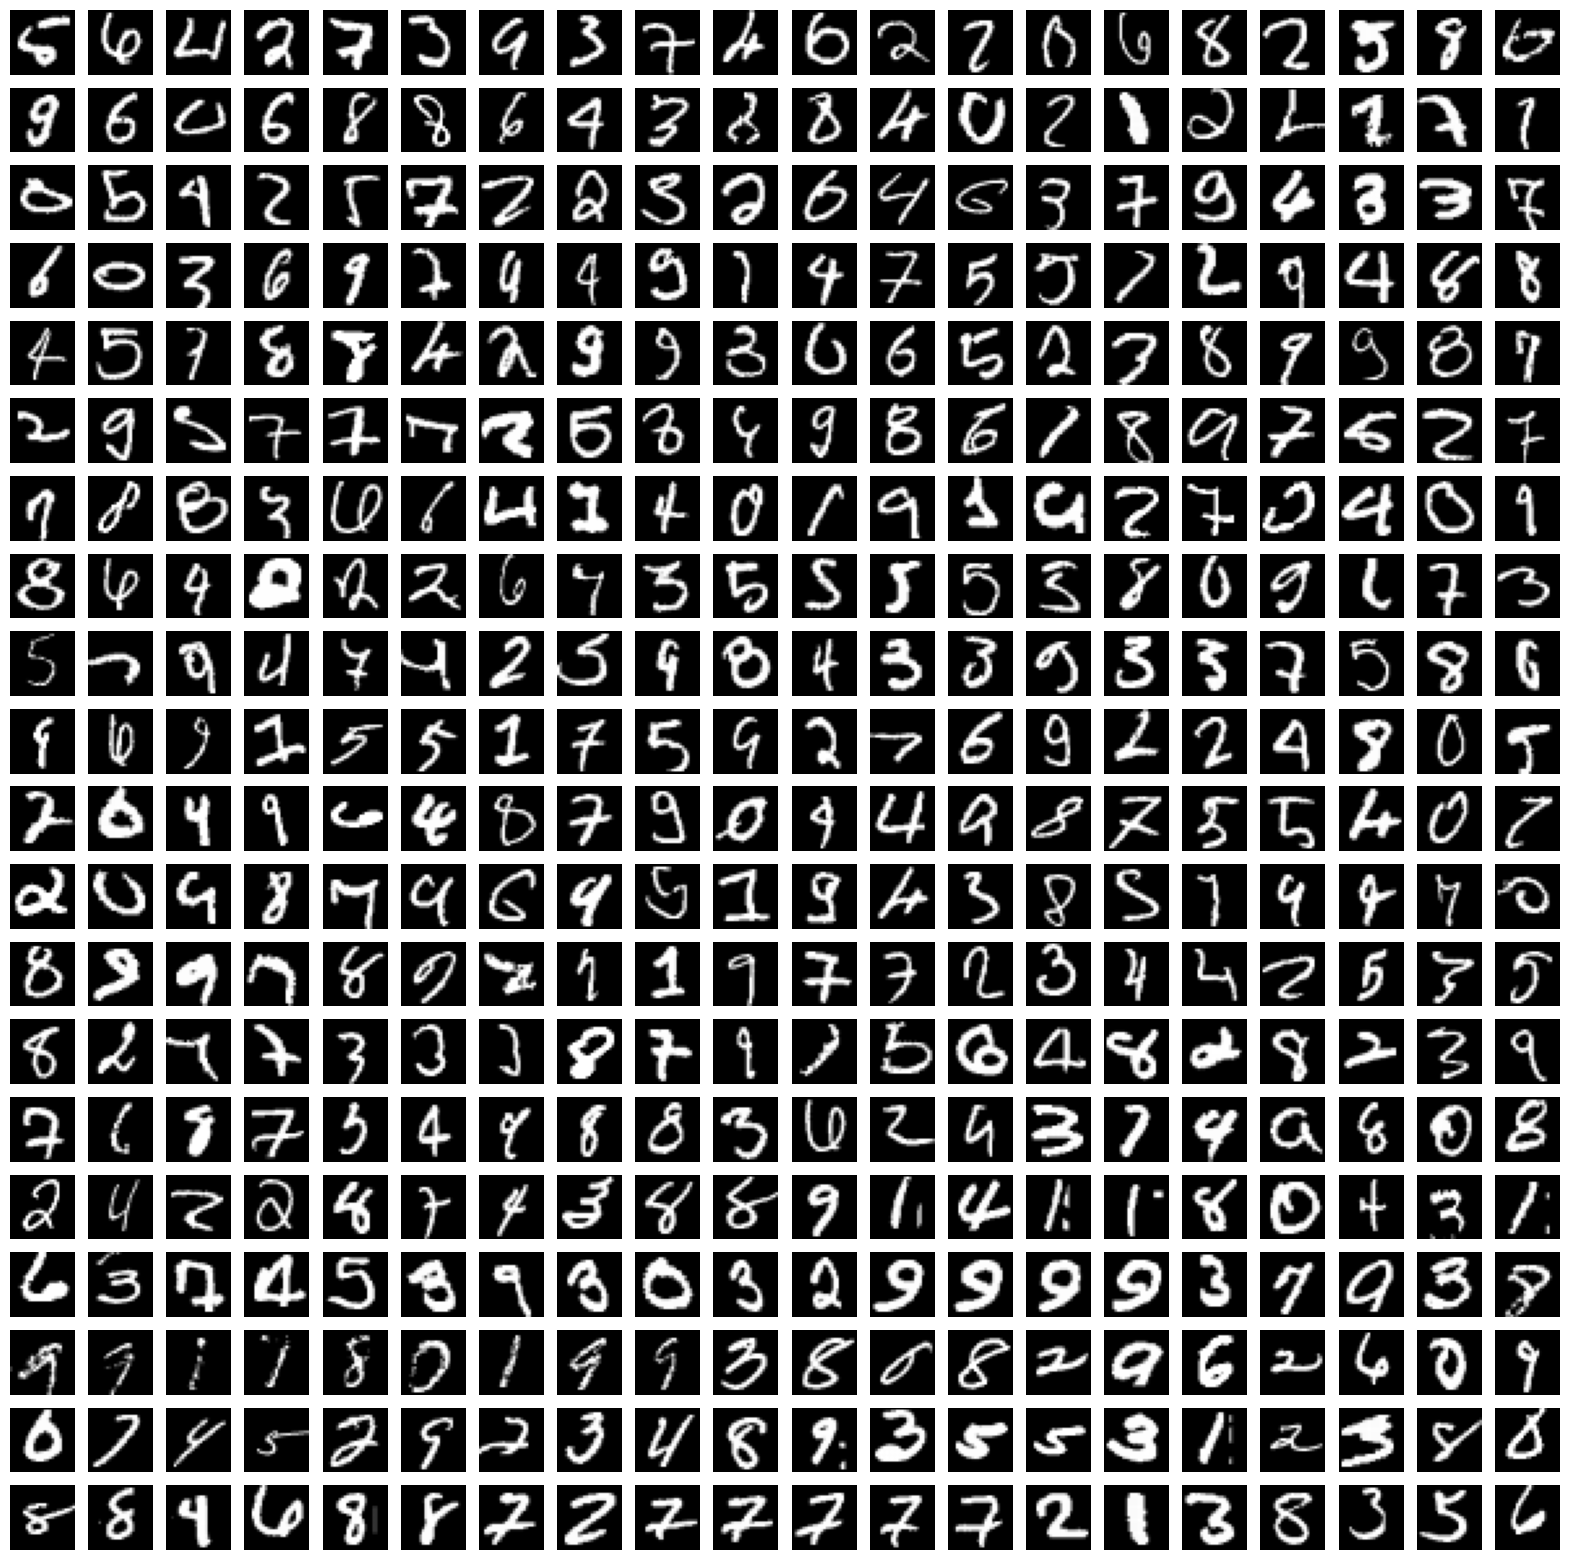

In [11]:
# use wrong idx to get the wrong images from test_images
wrong_images = test_images[wrong_idx]
# and plot first 400 of them in subplot(20,20)
fig = plt.figure(figsize=(20,20))
for i in range(400):
    ax = fig.add_subplot(20, 20, i+1)
    ax.imshow(wrong_images[i].reshape(25,25), cmap='gray')
    ax.axis('off')
plt.show()

### Fine turing

In [16]:
model = MainModel(device).to(device)
model.load_state_dict(torch.load('data/dianet_patch_mnist_49_25_reorder.pth'))

# test_images and test_dataset have same order
test_images = np.load('data/mnist25_test.npy')

test_loader2 = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)
# output a res, check the output
wrong_idx = []
model.eval()
with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader2):
        images = images.to(device)
        labels = labels.to(device)
        images = images.view(-1, 49, 25)
        outputs = model(images)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs.data, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        # append wrong idx
        if predicted != labels:
            wrong_idx.append(i)

print(len(wrong_idx)) # 373

373


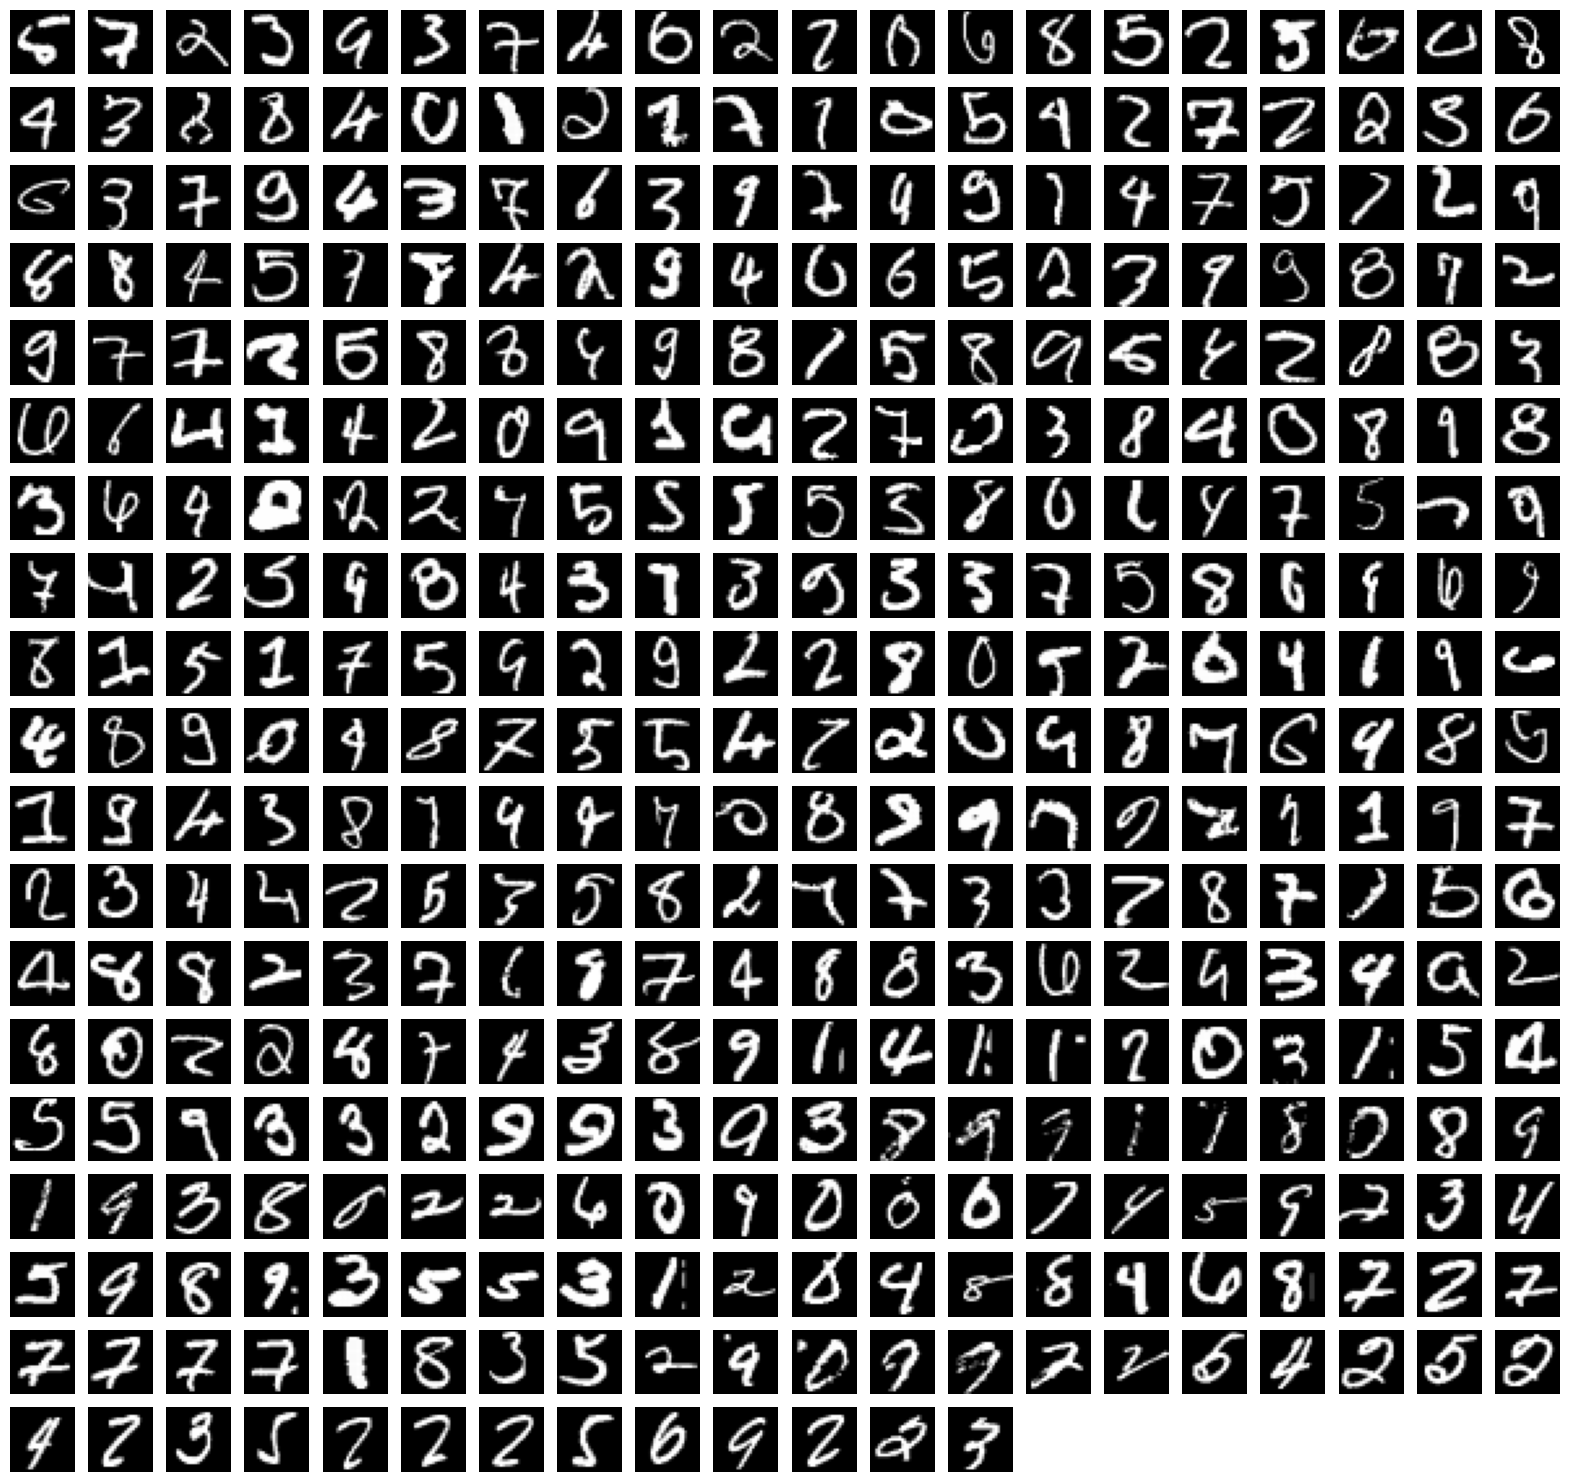

In [17]:
# use wrong idx to get the wrong images from test_images
wrong_images = test_images[wrong_idx]
# and plot first 400 of them in subplot(20,20)
fig = plt.figure(figsize=(20,20))
for i in range(373):
    ax = fig.add_subplot(20, 20, i+1)
    ax.imshow(wrong_images[i].reshape(25,25), cmap='gray')
    ax.axis('off')
plt.show()